# Population structure

With the advent of SNP data it is possible to precisely infer the genetic distance across individuals or populations. As written in the book, one way of doing it is by comparing each SNP from each individual against every other individual. This comparison produces the so called: covariance matrix, which in genetic terms means the number of shared polymorphisms across individuals.
There are many ways to visualize this data, in this tutorial you will be exposed to `Principal Component Analysis` and `Admixture` software.

We will use the R package `SNPRelate`, which can easily handle vcf files and do the PCA. If you want to explore a bit more on the functionality of the package access [here](https://www.rdocumentation.org/packages/SNPRelate/versions/1.6.4).

## How to make this notebook work

* In this notebook we will use both the `command line bash` commands and `R` to setup the file folders.
* Having to shift between two languages, you need to choose a kernel every time we shift from one language to another. A kernel contains a programming language and the necessary packages to run the course material. To choose a kernel, go on the menu on the top of the page and select `Kernel --> Change Kernel`, and then select the preferred one. We will shift between two kernels, and along the code in this notebook you will see a picture telling you to change kernel. The two pictures are below:

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

* You can run the code in each cell by clicking on the run cell sign in the toolbar, or simply by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>. When the code is done running, a small green check sign will appear on the left side.
* You need to run the cells in sequential order to execute the analysis. Please do not run a cell until the one above is done running, and do not skip any cells
* The code goes along with textual descriptions to help you understand what happens. Please try not to focus on understanding the code itself in too much detail - but rather try to focus on the explanations and on the output of the commands 
*   You can create new code cells by pressing `+` in the Menu bar above or by pressing <kbd>B</kbd> after you select a cell. 


## Learning outcomes

At the end of this tutorial you will be able to

- **Extract** information from a `vcf` file and create a PCA projection
- **Apply** LD pruning to reveal population structure

## Setting up folders

Here we setup a link to the `Data` folder and creagte the `Results` folder.

<img src="img/bash.png" alt="Bash" width="80"> Choose the `Bash` kernel

In [1]:
ln -s ../../Data
mkdir -p Results

In [2]:
gunzip -ck Data/vcf/Allvariants_135_145_chr2.vcf.gz > Results/Allvariants_135_145_chr2.vcf

# PCA from VCF data file

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

In [2]:
library(SNPRelate)
library(ggplot2)

Loading required package: gdsfmt

SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)



## Import data and calculate PCA

We read the metadata about the samples (geographic locations) and transform the `vcf` file into `gds` format, from which the package `SNPRelate` can calculate the PCA projection of the data.

In [3]:
# Reading the metadata information 
info = read.csv("Data/metadata/sample_infos_accessionnb.csv", header = T, sep = ';')

# Setting the directory of the VCF file 
vcf.fn <- "Results/Allvariants_135_145_chr2.vcf"

# Transforming the vcf file to gds format
snpgdsVCF2GDS(vcf.fn, "Results/Allvariants_135_145_chr2_2.gds", method="biallelic.only")

#Read the file and calculate the PCA
genofile <- snpgdsOpen("Results/Allvariants_135_145_chr2_2.gds",  FALSE, TRUE, TRUE)
pca <- snpgdsPCA(genofile)
summary(pca)

Start file conversion from VCF to SNP GDS ...
Method: extracting biallelic SNPs
Number of samples: 27
Parsing "Results/Allvariants_135_145_chr2.vcf" ...
	import 49868 variants.
+ genotype   { Bit2 27x49868, 328.7K } *
Optimize the access efficiency ...
Clean up the fragments of GDS file:
    open the file 'Results/Allvariants_135_145_chr2_2.gds' (519.6K)
    # of fragments: 50
    save to 'Results/Allvariants_135_145_chr2_2.gds.tmp'
    rename 'Results/Allvariants_135_145_chr2_2.gds.tmp' (519.3K, reduced: 360B)
    # of fragments: 20
Principal Component Analysis (PCA) on genotypes:
Excluding 0 SNP on non-autosomes
Excluding 397 SNPs (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 27
    # of SNPs: 49,471
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 2250084
CPU capabilities: Double-Precision SSE2
Tue Feb 28 15:10:26 2023    (internal increment: 101792)
[==================================================] 100%

          Length Class  Mode     
sample.id    27  -none- character
snp.id    49471  -none- numeric  
eigenval     27  -none- numeric  
eigenvect   729  -none- numeric  
varprop      27  -none- numeric  
TraceXTX      1  -none- numeric  
Bayesian      1  -none- logical  
genmat        0  -none- NULL     

**Q.1** How many individuals and snps does this dataset have? What is an eigenvector and an eigenvalue?

The `pca` object just created is a list containing various elements.

In [4]:
ls(pca)

[1] "Bayesian"  "eigenval"  "eigenvect" "genmat"    "sample.id" "snp.id"   
[7] "TraceXTX"  "varprop"

We use `pca$eigenvect` to plot the PCA. We extract also `pca$sample.id` to match the geographic locations in the metadata with the samples in `pca`.

In [5]:
eigenvectors = as.data.frame(pca$eigenvect[,1:5])
colnames(eigenvectors) = as.vector(sprintf("PC%s", seq(1:ncol(eigenvectors))))
pca$sample.id = sub("_chr2_piece_dedup", "", pca$sample.id)

# Matching the sample names with their origin and population
rownames(info) <- info[,"ENA.RUN"]
eigenvectors <- cbind(eigenvectors, info[pca$sample.id, c("population","region")])


In the end, we have created a table called `eigenvectors` containing the PCA coordinates and some metadata

In [6]:
head(eigenvectors)

,PC1,PC2,PC3,PC4,PC5,population,region
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ERR1019039,-0.08797594,-0.09112105,-0.018765738,-0.009707983,-0.034487827,Naxi,EastAsia
ERR1019060,-0.08922936,-0.12111275,-0.069492271,-0.002468963,-0.053851009,Miao,EastAsia
ERR1019074,-0.07715339,-0.08393755,-0.031730341,-0.005722997,-0.057211803,Japanese,EastAsia
ERR1019075,0.63590783,-0.18486541,0.026214440,-0.056798669,0.051522054,Ju_hoan_North,Africa
ERR1019076,0.66123851,-0.21762437,0.003079055,0.069235635,0.005858126,Ju_hoan_North,Africa
ERR1025598,-0.08093083,-0.10223892,-0.023168510,-0.021349088,-0.059966252,Atayal,EastAsia


Let's first look at how much of the variance of the data is explained by each eigenvector:

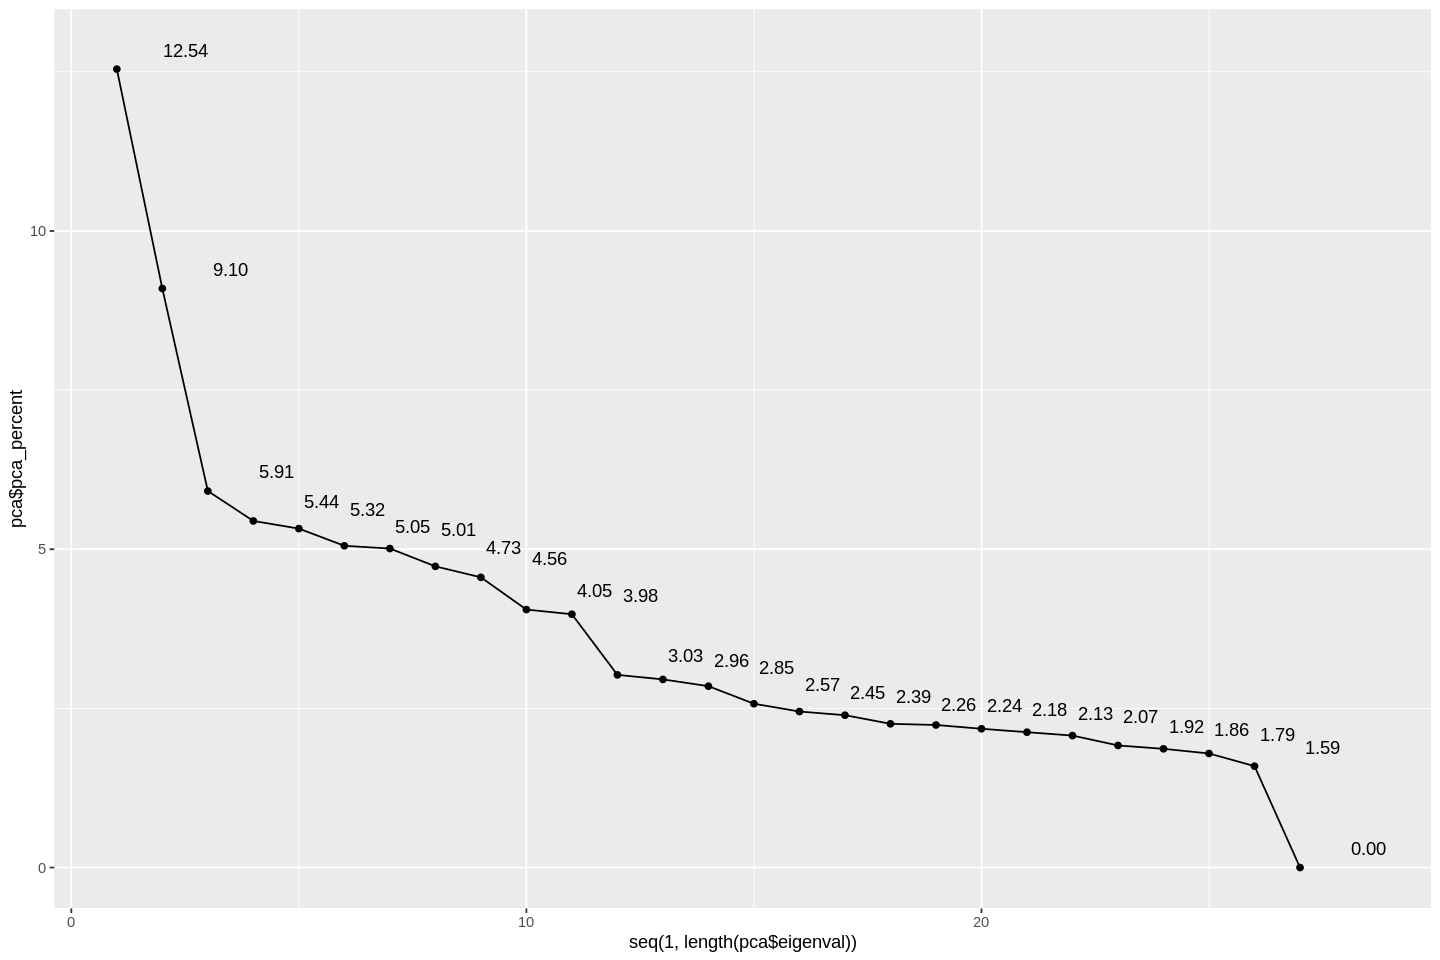

In [7]:
# Variance proportion:
pca$pca_percent <- pca$varprop*100
ggplot( NULL, aes(x=seq(1, length(pca$eigenval)), y=pca$pca_percent, label=sprintf("%0.2f", round(pca$pca_percent, digits = 2))) ) +
        geom_line() + geom_point() + 
        geom_text(nudge_y = .3, nudge_x = 1.5, check_overlap = T)

**Q.2** How many PC's do we need in order to explain 50% of the variance of the data? Can you make an accumulative plot of the variance explained PC?

## Visualization

We plot now the first two PCA coordinates and label them by Population, with color by region. We can see how only africans are separated from the rest, but the PCA is quite confused and cannot distinguish EastAsia and WestEurasia.

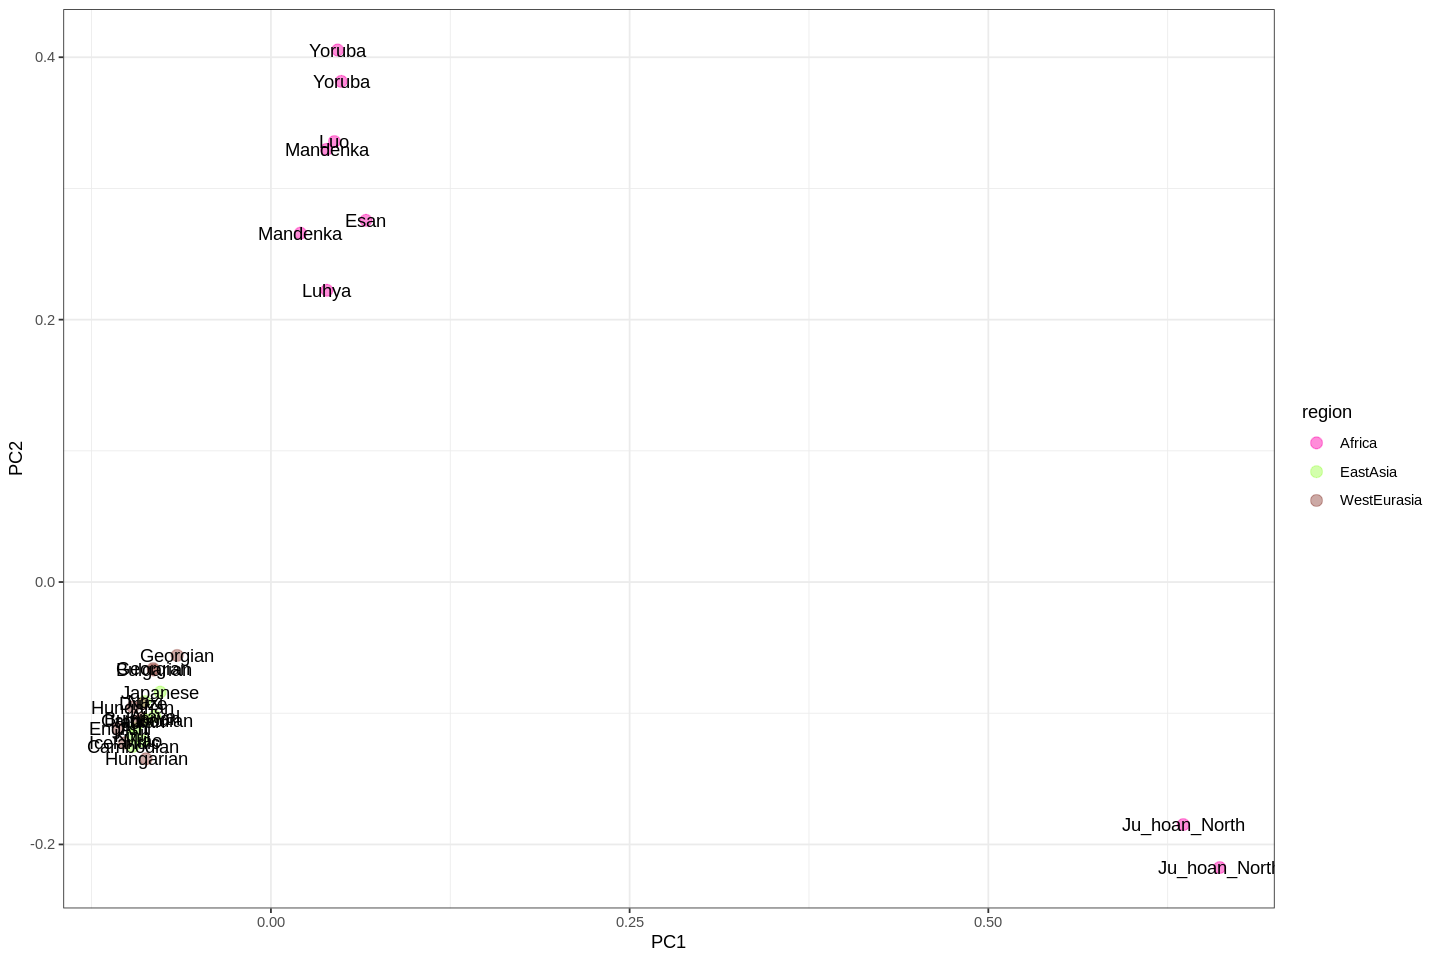

In [8]:
ggplot(data = eigenvectors, aes(x = PC1, y = PC2, col = region)) + 
        geom_point(size=3,alpha=0.5) + geom_text( aes(label=population), col="black") +
        scale_color_manual(values = c("#FF1BB3","#A7FF5B","#99554D")) +
        theme_bw()

**Q.3** Try to plot PC2 and PC3. Do you see the same patterns? What is the correlation between PC2 and PC3 (hint use the function cor())?

**Q.4** Try also to color the graph based on population. What do you observe?

## LD pruning

We implement LD pruning to eliminate those SNPs that are in high linkage disequilibrium, so that we avoid highly correlated SNPs that would alter our PCA. We end up keeping a handful of SNPs, but the population structure is now much more clear.

In [29]:
set.seed(1000)

# This function prune the snps with a thrshold of maximum 0.3 of LD
snpset <- snpgdsLDpruning(genofile, ld.threshold=0.3)

# Get all selected snp's ids
snpset.id <- unlist(snpset)

pca_pruned <- snpgdsPCA(genofile, snp.id=snpset.id, num.thread=2)

#add metadata
eigenvectors = as.data.frame(pca_pruned$eigenvect)
colnames(eigenvectors) = as.vector(sprintf("PC%s", seq(1:nrow(pca$eigenvect))))
pca_pruned$sample.id = sub("_chr2_piece_dedup", "", pca$sample.id)
eigenvectors <- cbind(eigenvectors, info[pca$sample.id, c("population","region")])

#plot
ggplot(data = eigenvectors, aes(x = PC3, y = PC2, col = region, label=population)) + 
        geom_text(hjust=1, vjust=0, angle=45) +
        geom_point(size=3,alpha=0.5) +
        scale_color_manual(values = c("#FF1BB3","#A7FF5B","#99554D")) +
        theme_bw() + coord_flip()

ERROR: Error in snpgdsLDpruning(genofile, ld.threshold = 0.3): could not find function "snpgdsLDpruning"


**Q.5** Implement different LD thresholds (0.1, 0.2, 0.3, 0.4, 0.5). How many SNPs are left after each filtering threshold? Are these SNPs linked?

Now we are going to convert this GDS file into a plink format, to be later used in the admixture exercise:

In [10]:
snpgdsGDS2BED(genofile, "Results/chr2_135_145_flt_prunned.gds", sample.id=NULL, snp.id=snpset.id, snpfirstdim=NULL, verbose=TRUE)

Converting from GDS to PLINK binary PED:
Working space: 27 samples, 607 SNPs
Output a BIM file.
Output a BED file ...
		Tue Feb 28 15:10:28 2023	0%
		Tue Feb 28 15:10:28 2023	100%
Done.


Save the data for later

In [11]:
save(pca, pca_pruned, info, genofile, file = "Results/data.Rdata")

# Admixture Estimation

<img src="img/bash.png" alt="Bash" width="80"> Choose the `Bash` kernel

`Admixture` is a program for estimating ancestry in a model based manner from SNP genotype datasets, where individuals are unrelated. The input format required by the software is in binary PLINK (`.bed`) file. That is why we converted our vcf file into `.bed`.

Now with adjusted format and pruned snps, we are ready to run the admixture analysis. We believe that our individuals are derived from three ancestral populations:

In [1]:
admixture Results/chr2_135_145_flt_prunned.gds.bed 3
#move output files with other results
mv chr2_135_145_flt_prunned.gds.3.P chr2_135_145_flt_prunned.gds.3.Q  Results/

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 27x607
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0.002	Loglikelihood: -6472.91	(delta): 19992
2 (EM) 	Elapsed: 0.001	Loglikelihood: -6018.01	(delta): 454.903
3 (EM) 	Elapsed: 0.001	Loglikelihood: -5

**Q.6** Have a look at the Fst across populations, that is printed in the terminal. Would you guess which populations are Pop0, Pop1 and Pop2 referring to?

After running admixture, 2 outputs are generated:

- `Q`: the ancestry fractions

- `P`: the allele frequencies of the inferred ancestral populations

Sometimes we may have no priori about `K`, one good way of choosing the best `K` is by doing a cross-validation procedure impletemented in admixture as follow:

In [6]:
for K in 1 2 3 4 5
do 
    admixture --cv Results/chr2_135_145_flt_prunned.gds.bed $K | tee log${K}.out
    mv chr2_135_145_flt_prunned.gds.$K.* log$K.out Results/
done

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 27x607
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0	Loglikelihood: -6143.9	(delta): 27247.3
2 (EM) 	Elapsed: 0	Loglikelihood: -6143.9	(delta): 0
3 (EM) 	

Have a look at the Cross Validation error of each `K`:

In [7]:
grep -h CV Results/log*.out

CV error (K=1): 0.46577
CV error (K=2): 0.47280
CV error (K=3): 0.50909
CV error (K=4): 0.55229
CV error (K=5): 0.60404


Save it in a text file:

In [8]:
grep -h CV Results/log*.out > Results/CV_logs.txt

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

Look at the distribution of CV error.

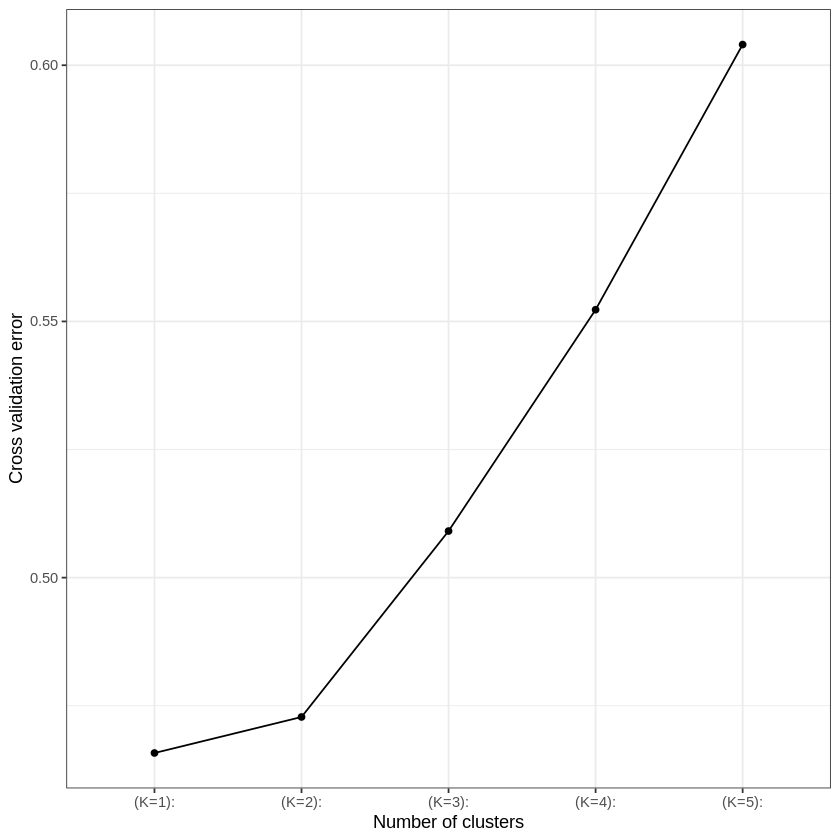

In [1]:
library(ggplot2)

CV = read.table('Results/CV_logs.txt')

p <- ggplot(data = CV, aes(x = V3, y = V4, group = 1)) + 
    geom_line() + geom_point() + theme_bw() + 
    labs(x = 'Number of clusters', y = 'Cross validation error')

p

**Q.7** What do you understand of Cross validation error? Based on this graph, what is the best `K`?

Plotting the `Q` estimates. Choose the `K` that makes more sense to you and substitute it in the first line of code (right now it is `K=3`)

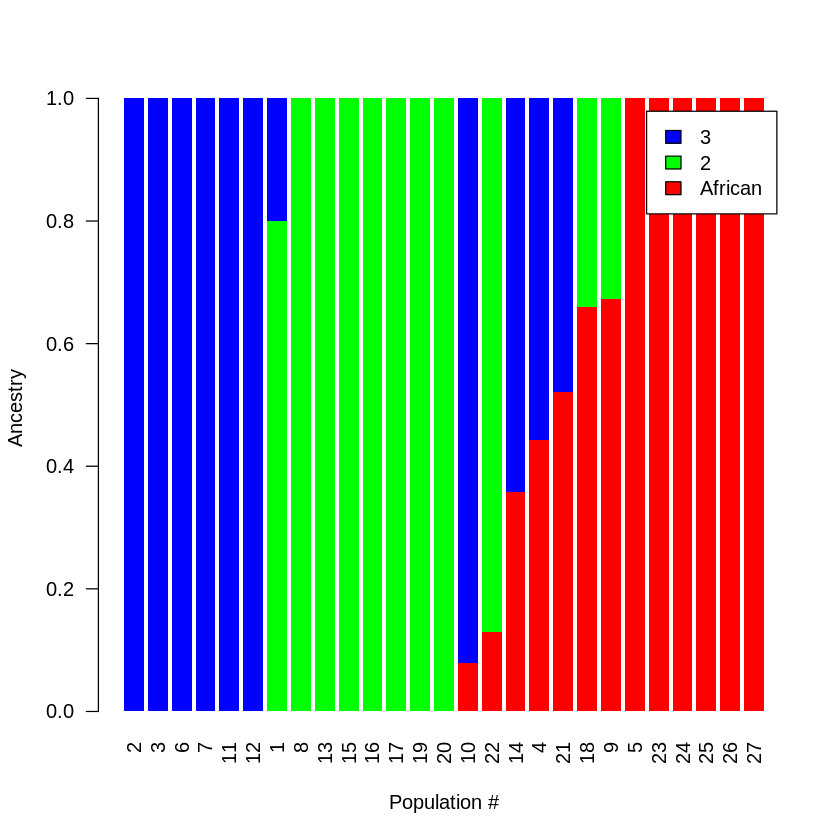

In [5]:
tbl = read.table("Results/chr2_135_145_flt_prunned.gds.3.Q")
ord = tbl[order(tbl$V1,tbl$V2,tbl$V3),]
bp = barplot(t(as.matrix(ord)), legend.text = c("African", "2", "3"),
            space = c(0.2),
            col=rainbow(3),
            xlab="Population #", 
            ylab="Ancestry",
            border=NA,
            las=2)

Note: Here we order the X-axis based on proportions for the first population component. However, you will see that in the HapMap data all the individuals show some portion of this component and the different individuals are more admixed in general, i.e they are no longer explained by mostly one component, it’s not useful to use that kind of ordering anymore to interpret the plot. Instead, we should keep the original order, since the files are originally ordered by population, and we should plot each population on the X axis to be able to interpret the plot. This can be achieved with something of the type:

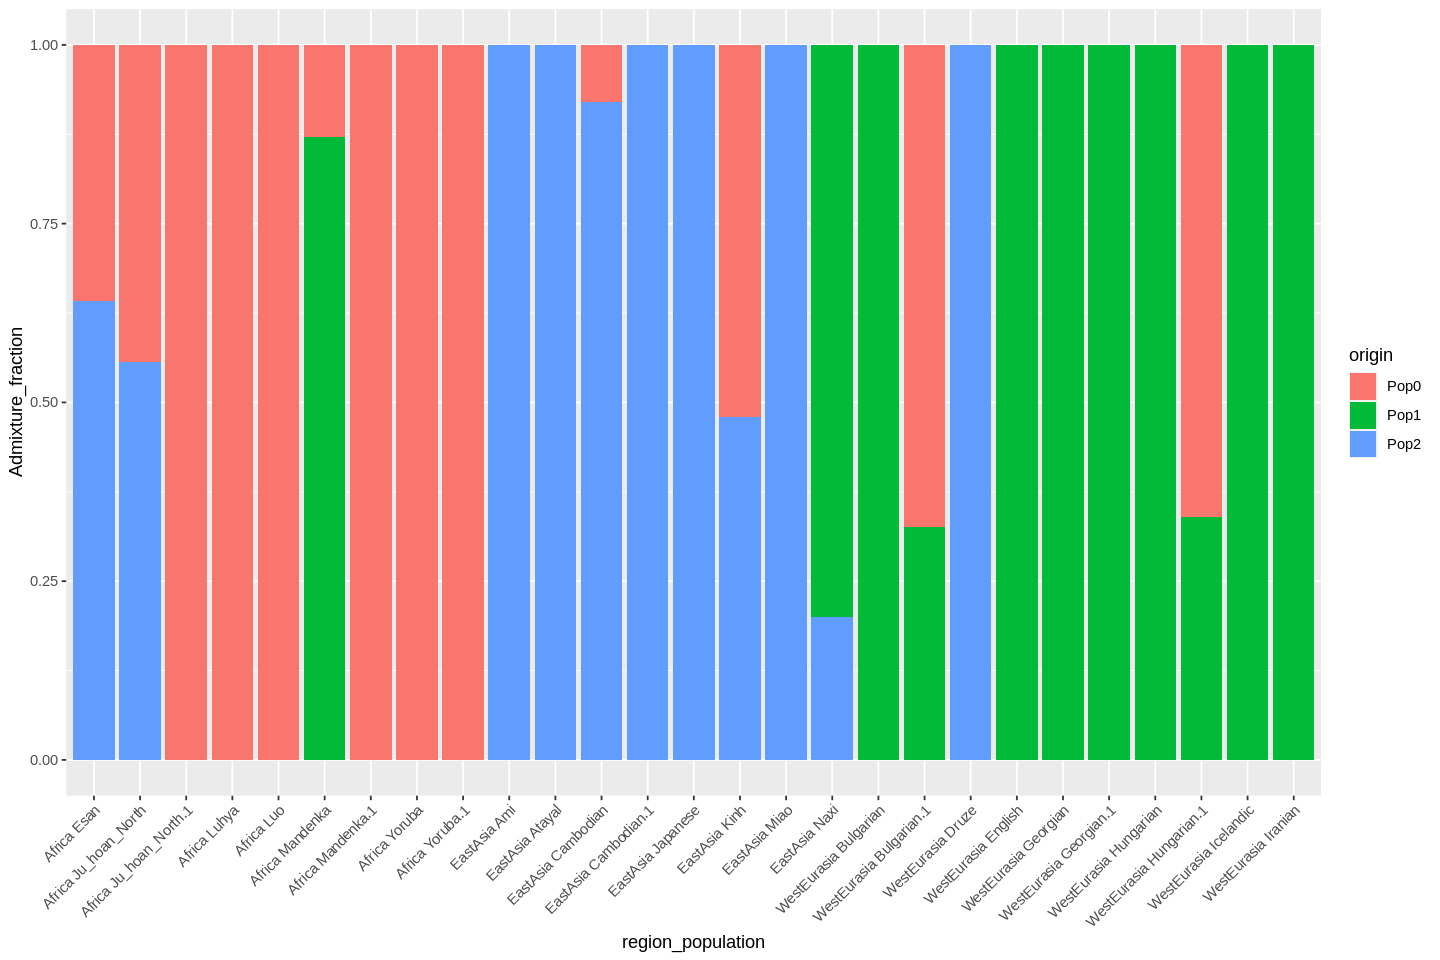

In [28]:
library(dplyr)
library(ggplot2)
load("Results/data.Rdata")

#resize plot
options(repr.plot.width = 12, repr.plot.height = 8)

K=3

tbl = read.table( paste("Results/chr2_135_145_flt_prunned.gds.",K,".Q", sep="") )

origin <- rep( paste( rep("Pop", K), as.character(c(0:(K-1))), sep="" ) , each=dim(tbl)[1] )
population <- info[ pca$sample.id, ]$population
region <- info[ pca$sample.id, ]$region
regpop <- make.unique( paste(region, population) )

tbl <- as.data.frame(unlist(tbl))
colnames(tbl) <- 'Admixture_fraction'
tbl['origin'] = origin
tbl['population'] = rep(population,K)
tbl['region'] = region
tbl['region_population'] = regpop

ggplot(tbl, aes(fill=origin, y=Admixture_fraction, x=region_population)) +
    geom_bar(position="stack", stat="identity") + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

**Q.8** How many clusters do you identify in this plot? Does that agree with what was found using PCA?

In the following part of this exercise you will do both analysis (PCA and Admixture) using a different dataset. The data comes from the HAPMAP Consortium, to learn more about the populations studied in this project access here. The vcf file `hapmap.vcf`, an information file `relationships_w_pops_121708.txt`, as well as `.bim, .bed, .fam` files (only to be used if you get stuck during the exercise) are available for the admixture analysis. This dataset is placed here:

`Data/assignment`